# Image classification

In [1]:
import time
from collections import OrderedDict

import numpy as np
import torch
import torchvision
from IPython.display import display
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.neighbors import NearestCentroid

In [2]:
labels = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [3]:
data = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=True, download=True)
train_x = np.array(data.data)
train_y = np.array(data.targets)

data = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=False, download=True)
val_x = np.array(data.data[:5000])
val_y = np.array(data.targets[:5000])
test_x = np.array(data.data[5000:10000])
test_y = np.array(data.targets[5000:10000])

In [4]:
data = []
columns = [*labels, 'total']
for y in [train_y, val_y, test_y]:
    _, counts = np.unique(y, return_counts=True)
    data.append([*counts, y.shape[0]])
display(DataFrame(data, index=['training set', 'validation set', 'test set'], columns=columns))

,top,trousers,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot,total
training set,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,60000
validation set,507,481,521,500,521,485,482,500,526,477,5000
test set,493,519,479,500,479,515,518,500,474,523,5000


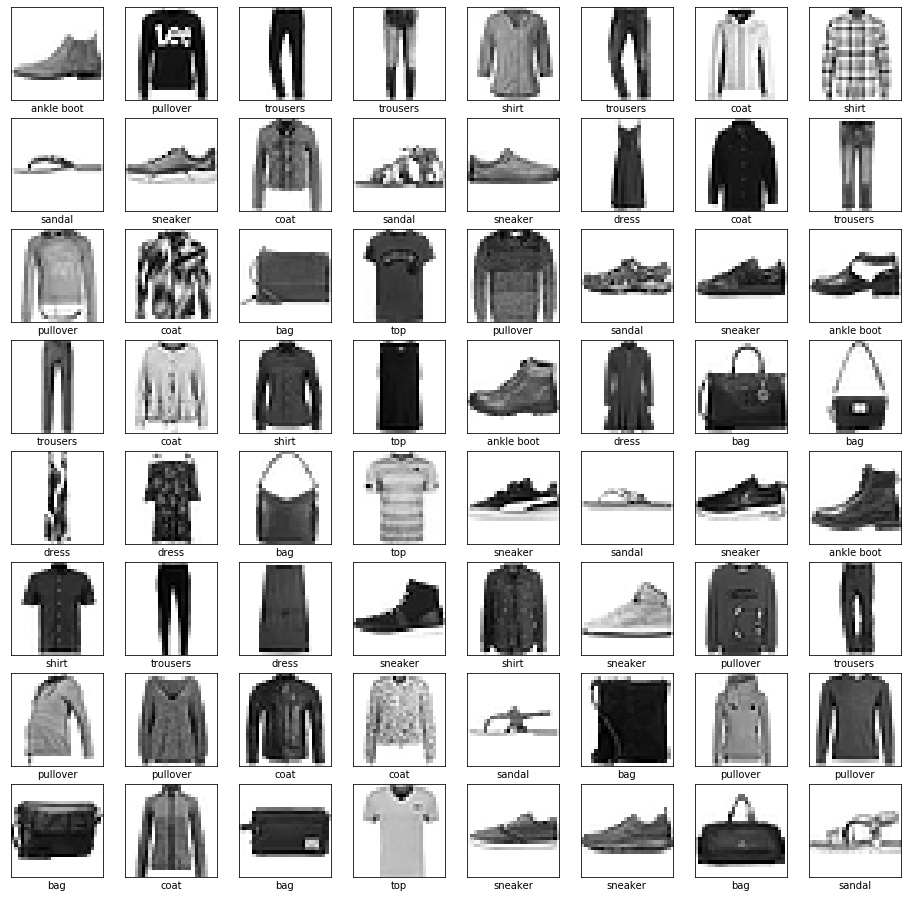

In [5]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(val_x[i], cmap=plt.cm.binary)
    plt.xlabel(labels[val_y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

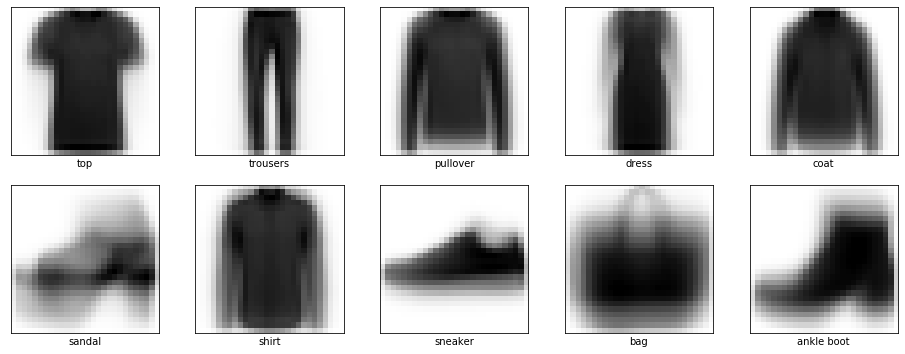

In [6]:
centroids = [(l, train_x[train_y == i].mean(axis=0)) for i, l in enumerate(labels)]
plt.figure(figsize=(16, 6))
for i, (label, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])
plt.show()

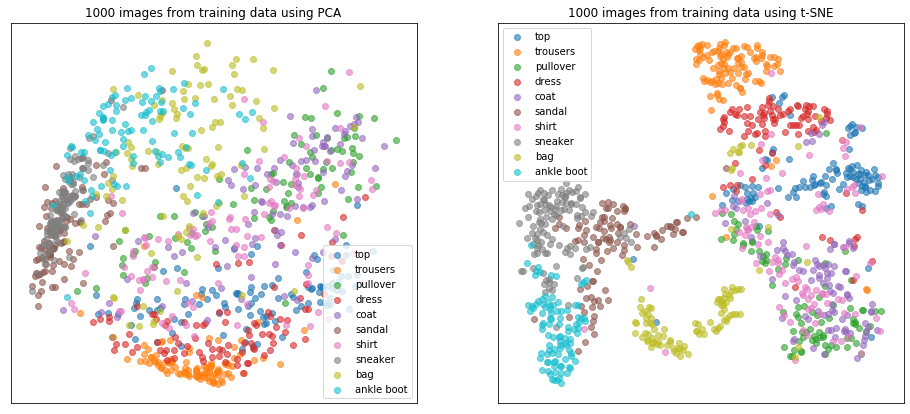

In [7]:
plt.figure(figsize=(16, 7))
for i, (name, alg) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x_reduced = alg.fit_transform(train_x[:1000].reshape(-1, 784))
    y_reduced = train_y[:1000]
    data = [(l, x_reduced[y_reduced == i]) for i, l in enumerate(labels)]
    plt.subplot(1, 2, i + 1)
    for label, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=label)
    plt.title(f'1000 images from training data using {name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
def plot_history(history):
    plt.figure(figsize=(16, 5))
    for i, (name, key) in enumerate([('accuracy', 'acc'), ('loss', 'loss')]):
        plt.subplot(1, 2, i + 1)
        plt.plot(history['epoch'], history[key], label=f'training {name}')
        plt.plot(history['epoch'], history[f'val_{key}'], label=f'validation {name}')
        plt.title(f'{name} during training')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel(name)
    plt.show()

def plot_predictions(model, x=val_x[:64], y=val_y[:64], labels=labels):
    y_pred = model.predict(x)
    n = np.ceil(np.sqrt(x.shape[0]))
    plt.figure(figsize=(16, 18))
    for i in range(x.shape[0]):
        plt.subplot(n, n, i + 1)
        plt.imshow(x[i], cmap=plt.cm.binary)
        plt.xlabel(
            f'pred: {labels[y_pred[i]]}\ntrue: {labels[y[i]]}',
            color='green' if y_pred[i] == y[i] else 'red')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [9]:
models = OrderedDict()

In [10]:
class SKLearnClassifier:

    def __init__(self, model):
        self.model = model

    def fit(self, train_x, train_y):
        start = time.time()
        self.model.fit(train_x.reshape(train_x.shape[0], -1), train_y)
        print(f'Finished training in {time.time() - start:.2f}s')

    def predict(self, x):
        return self.model.predict(x.reshape(x.shape[0], -1))

In [11]:
models['nearest centroid'] = SKLearnClassifier(NearestCentroid(metric='euclidean'))

In [12]:
models['nearest centroid'].fit(train_x, train_y)

Finished training in 0.05s


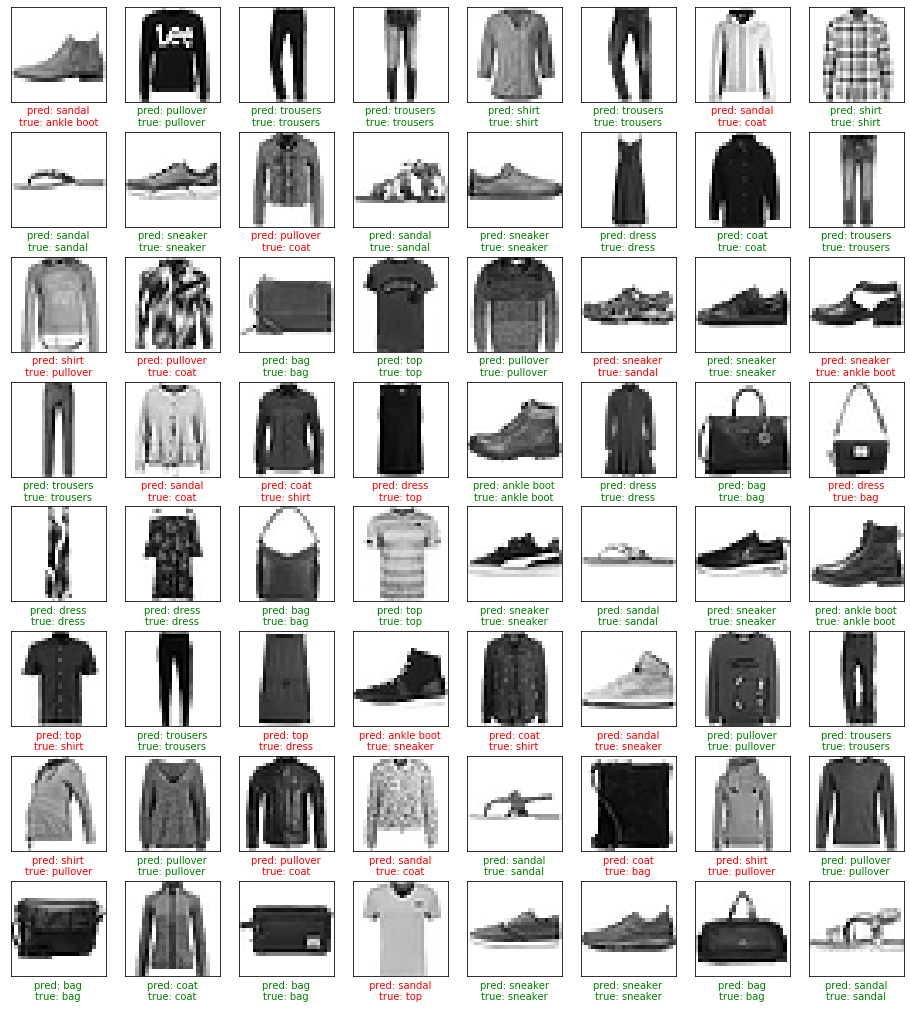

In [13]:
plot_predictions(models['nearest centroid'])

In [14]:
models['random forest'] = SKLearnClassifier(
    RandomForestClassifier(n_estimators=50, max_depth=25, n_jobs=-1))

In [15]:
models['random forest'].fit(train_x, train_y)

Finished training in 6.85s


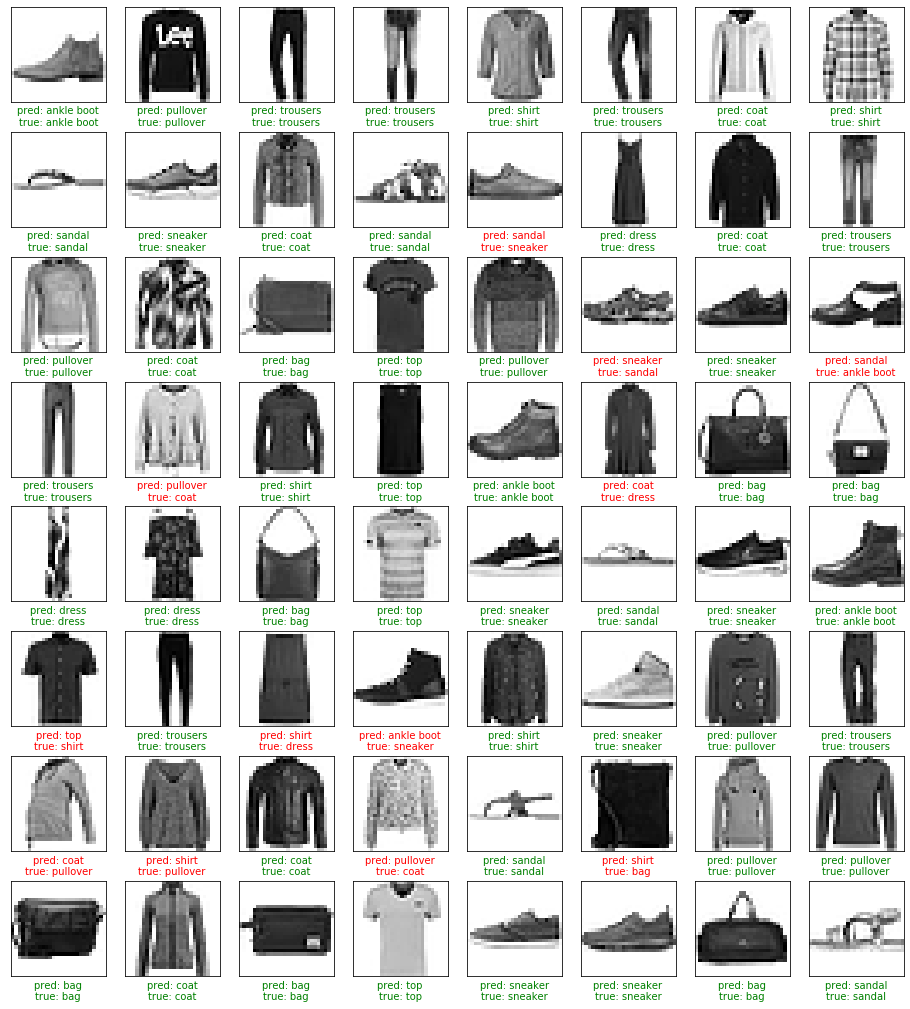

In [16]:
plot_predictions(models['random forest'])

In [17]:
class PyTorchClassifier(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_x, train_y, val_x, val_y, epochs, batch_size=250, shuffle=True):
        self.to(self.device)
        train_loader = self._build_loader_xy(
            train_x, train_y, batch_size=batch_size, shuffle=shuffle)
        val_loader = self._build_loader_xy(val_x, val_y, batch_size=1000, shuffle=False)
        history = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(1, epochs+1):
            self.train()
            start_time = time.time()
            loss, acc = 0, 0
            for x, y in train_loader:
                # Batch training step
                self.optimizer.zero_grad()
                x, y = x.to(self.device), y.to(self.device)
                y_pred = self(x)
                loss_ = self.loss(y_pred, y)
                loss_.backward()
                self.optimizer.step()
                # Calculate metrics for batch
                loss += float(loss_) * len(x)
                acc += int((y_pred.argmax(dim=1) == y).sum())
            # Calculate metrics for epoch
            loss /= len(train_loader.dataset)
            acc /= len(train_loader.dataset)
            val_loss, val_acc = self._evaluate(val_loader)
            duration = time.time() - start_time
            # Save training history
            history['epoch'].append(epoch)
            history['loss'].append(loss)
            history['acc'].append(acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print(
                f'[{epoch:{len(str(epochs))}}/{epochs}] {duration:.1f}s'
                f' - loss: {loss:.4f} - acc: {acc:.4f}'
                f' - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')
        return history

    def predict(self, x, batch_size=1000):
        self.to(self.device)
        data_loader = self._build_loader_x(x, batch_size=batch_size, shuffle=False)
        self.eval()
        preds = []
        for x, in data_loader:
            x = x.to(self.device)
            preds.extend(self(x).argmax(dim=1).cpu())
        return np.array(preds)

    def _evaluate(self, data_loader):
        self.to(self.device)
        self.eval()
        loss, acc = 0, 0
        for x, y in data_loader:
            x, y = x.to(self.device), y.to(self.device)
            y_pred = self(x)
            loss += float(self.loss(y_pred, y)) * len(x)
            acc += int((y_pred.argmax(dim=1) == y).sum())
        loss /= len(data_loader.dataset)
        acc /= len(data_loader.dataset)
        return loss, acc

    @staticmethod
    def _build_loader_x(x, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 255),
            batch_size=batch_size, shuffle=shuffle)

    @staticmethod
    def _build_loader_xy(x, y, batch_size, shuffle):
        return torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.FloatTensor(x) / 255, torch.LongTensor(y)),
            batch_size=batch_size, shuffle=shuffle)

In [18]:
class MultilayerPerceptron(PyTorchClassifier):

    def __init__(self):
        super().__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
        ])
        
        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [19]:
models['multilayer perceptron'] = MultilayerPerceptron()

In [20]:
history = models['multilayer perceptron'].fit(train_x, train_y, val_x, val_y, epochs=50)

[ 1/50] 0.8s - loss: 0.7280 - acc: 0.7490 - val_loss: 0.5386 - val_acc: 0.8092
[ 2/50] 0.7s - loss: 0.5048 - acc: 0.8221 - val_loss: 0.4462 - val_acc: 0.8482
[ 3/50] 0.7s - loss: 0.4565 - acc: 0.8376 - val_loss: 0.4148 - val_acc: 0.8548
[ 4/50] 0.7s - loss: 0.4312 - acc: 0.8450 - val_loss: 0.3944 - val_acc: 0.8626
[ 5/50] 0.8s - loss: 0.4126 - acc: 0.8514 - val_loss: 0.3827 - val_acc: 0.8644
[ 6/50] 0.7s - loss: 0.4000 - acc: 0.8551 - val_loss: 0.3776 - val_acc: 0.8724
[ 7/50] 0.7s - loss: 0.3883 - acc: 0.8578 - val_loss: 0.3678 - val_acc: 0.8652
[ 8/50] 0.7s - loss: 0.3796 - acc: 0.8623 - val_loss: 0.3594 - val_acc: 0.8670
[ 9/50] 0.7s - loss: 0.3729 - acc: 0.8629 - val_loss: 0.3690 - val_acc: 0.8624
[10/50] 0.7s - loss: 0.3654 - acc: 0.8658 - val_loss: 0.3557 - val_acc: 0.8758
[11/50] 0.7s - loss: 0.3593 - acc: 0.8680 - val_loss: 0.3475 - val_acc: 0.8738
[12/50] 0.7s - loss: 0.3545 - acc: 0.8705 - val_loss: 0.3457 - val_acc: 0.8742
[13/50] 0.7s - loss: 0.3505 - acc: 0.8696 - val_loss

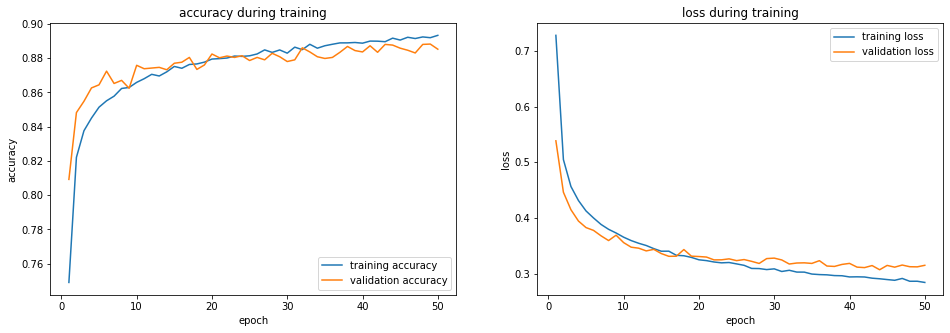

In [21]:
plot_history(history)

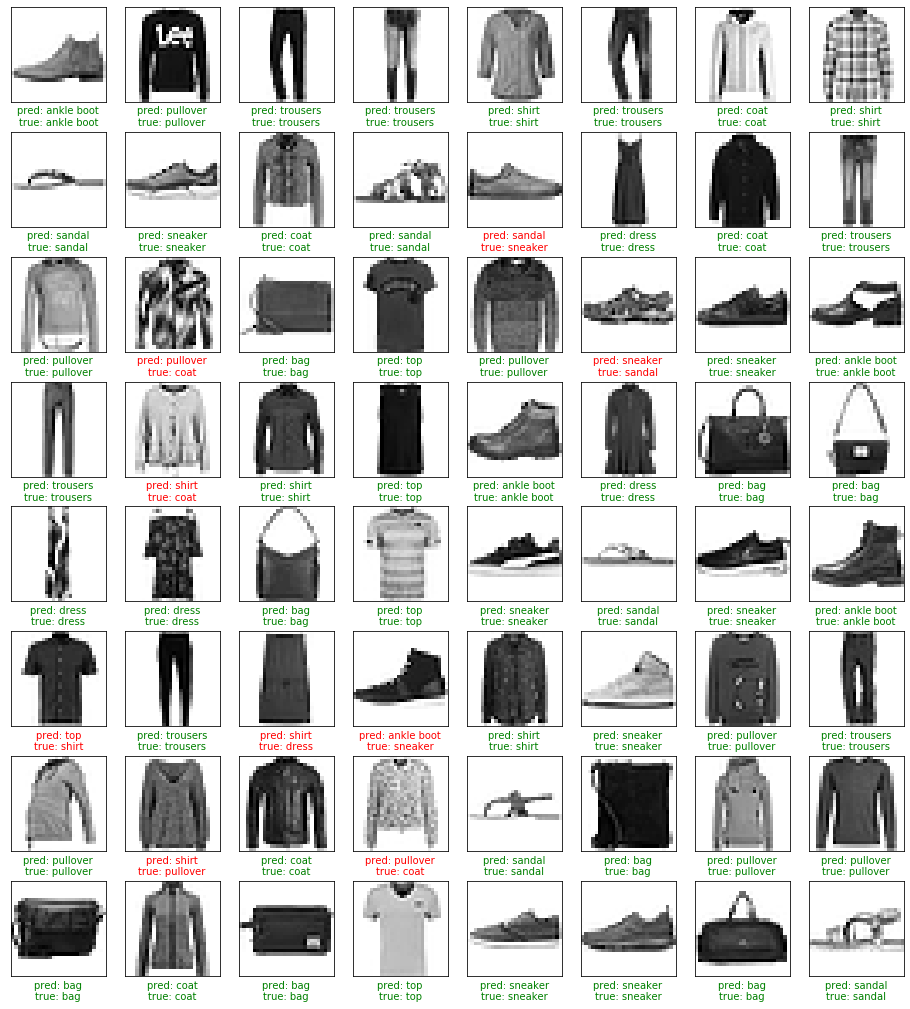

In [22]:
plot_predictions(models['multilayer perceptron'])

In [23]:
class ConvolutionalNet(PyTorchClassifier):

    def __init__(self):
        super().__init__()
        self.layers1 = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.25),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Dropout2d(0.25),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.layers2 = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
        ])

        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], 1, *x.size()[1:])
        for layer in self.layers1:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.layers2:
            x = layer(x)
        return x

In [24]:
models['convolutional net'] = ConvolutionalNet()

In [25]:
history = models['convolutional net'].fit(train_x, train_y, val_x, val_y, epochs=50)

[ 1/50] 3.5s - loss: 0.9055 - acc: 0.6655 - val_loss: 0.5922 - val_acc: 0.7768
[ 2/50] 3.1s - loss: 0.5827 - acc: 0.7854 - val_loss: 0.4763 - val_acc: 0.8256
[ 3/50] 3.1s - loss: 0.4980 - acc: 0.8184 - val_loss: 0.4224 - val_acc: 0.8476
[ 4/50] 3.2s - loss: 0.4558 - acc: 0.8335 - val_loss: 0.3942 - val_acc: 0.8566
[ 5/50] 3.1s - loss: 0.4218 - acc: 0.8450 - val_loss: 0.3702 - val_acc: 0.8652
[ 6/50] 3.0s - loss: 0.3996 - acc: 0.8524 - val_loss: 0.3604 - val_acc: 0.8646
[ 7/50] 3.0s - loss: 0.3816 - acc: 0.8604 - val_loss: 0.3532 - val_acc: 0.8726
[ 8/50] 3.0s - loss: 0.3679 - acc: 0.8641 - val_loss: 0.3344 - val_acc: 0.8782
[ 9/50] 3.2s - loss: 0.3576 - acc: 0.8683 - val_loss: 0.3232 - val_acc: 0.8818
[10/50] 3.0s - loss: 0.3434 - acc: 0.8724 - val_loss: 0.3172 - val_acc: 0.8824
[11/50] 3.0s - loss: 0.3368 - acc: 0.8759 - val_loss: 0.3152 - val_acc: 0.8868
[12/50] 3.0s - loss: 0.3292 - acc: 0.8781 - val_loss: 0.3064 - val_acc: 0.8918
[13/50] 3.0s - loss: 0.3214 - acc: 0.8811 - val_loss

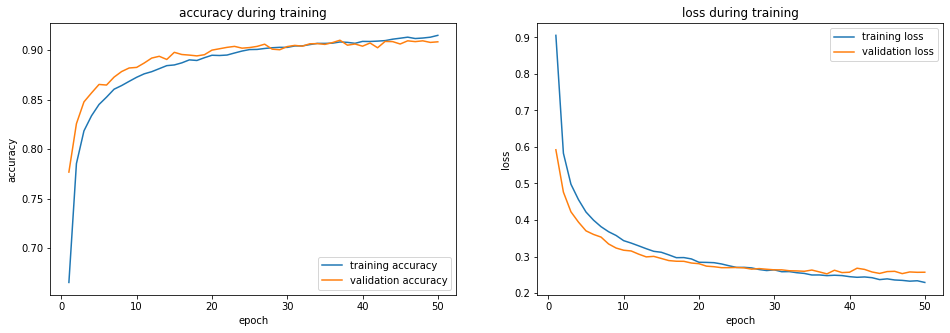

In [26]:
plot_history(history)

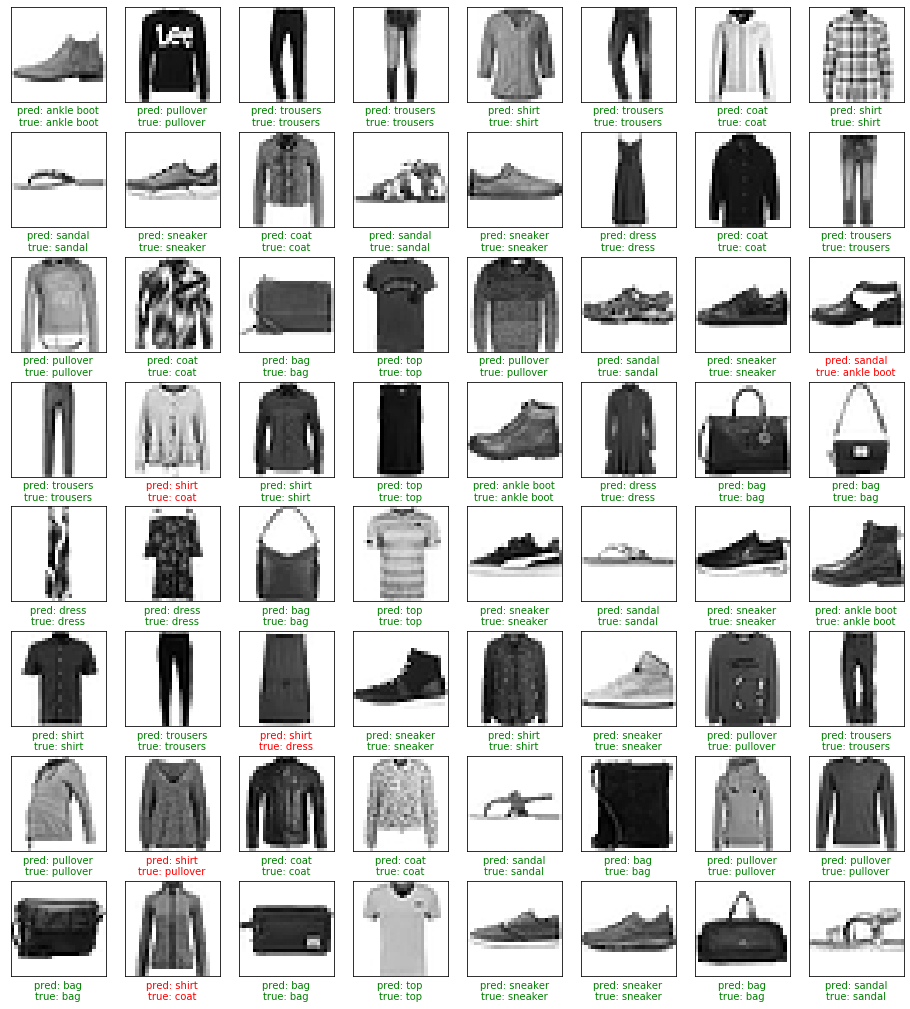

In [27]:
plot_predictions(models['convolutional net'])

In [28]:
data = []
columns = []
for name, model in models.items():
    data.append([
        f'{accuracy_score(train_y, model.predict(train_x)):.3f}',
        f'{accuracy_score(val_y, model.predict(val_x)):.3f}',
        f'{accuracy_score(test_y, model.predict(test_x)):.3f}'])
    columns.append(name)
data = np.array(data).T
display(DataFrame(data, index=['training set', 'validation set', 'test set'], columns=columns))

,nearest centroid,random forest,multilayer perceptron,convolutional net
training set,0.686,0.998,0.921,0.941
validation set,0.675,0.874,0.885,0.908
test set,0.678,0.874,0.892,0.916


In [29]:
data = []
columns = [[], []]
for name, model in models.items():
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_y, model.predict(test_x))
    data.extend([
        [f'{s:.3f}' for s in precision],
        [f'{s:.3f}' for s in recall],
        [f'{s:.3f}' for s in fscore]])
    columns[0].extend([name] * 3)
    columns[1].extend(['precision', 'recall', 'f-score'])
data = np.array(data).T
display(DataFrame(data, index=labels, columns=columns))

nearest centroid                random forest                 \
                  precision recall f-score     precision recall f-score   
top                   0.712  0.696   0.704         0.818  0.850   0.834   
trousers              0.976  0.867   0.918         0.996  0.956   0.975   
pullover              0.538  0.457   0.494         0.763  0.785   0.774   
dress                 0.688  0.750   0.718         0.874  0.914   0.893   
coat                  0.505  0.564   0.533         0.753  0.816   0.784   
sandal                0.511  0.767   0.613         0.984  0.957   0.970   
shirt                 0.331  0.212   0.259         0.701  0.583   0.636   
sneaker               0.765  0.834   0.798         0.925  0.958   0.941   
bag                   0.904  0.751   0.820         0.947  0.975   0.960   
ankle boot            0.867  0.872   0.869         0.956  0.945   0.950   

           multilayer perceptron                convolutional net         \
                       precision recall f-score         precision recall   
top                        0.840  0.852   0.846             0.850  0.888   
trousers                   0.986  0.967   0.977             0.986  0.983   
pullover                   0.828  0.785   0.806             0.814  0.931   
dress                      0.885  0.928   0.906             0.920  0.938   
coat                       0.786  0.843   0.814             0.867  0.843   
sandal                     0.990  0.950   0.969             0.981  0.981   
shirt                      0.720  0.670   0.694             0.824  0.685   
sneaker                    0.934  0.970   0.952             0.948  0.980   
bag                        0.979  0.983   0.981             0.979  0.981   
ankle boot                 0.956  0.966   0.961             0.982  0.950   

                    
           f-score  
top          0.869  
trousers     0.985  
pullover     0.869  
dress        0.929  
coat         0.855  
sandal       0.981  
shirt        0.748  
sneaker      0.964  
bag          0.980  
ankle boot   0.966

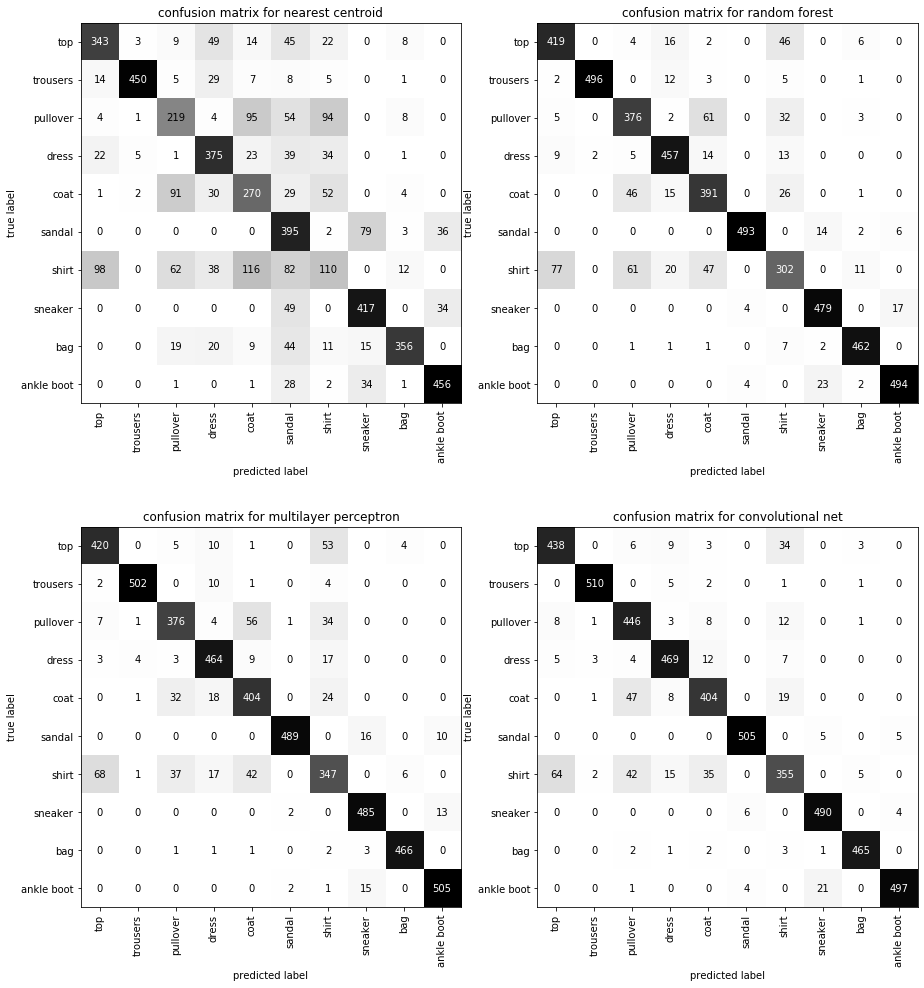

In [30]:
plt.figure(figsize=(15, 17))
for i, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(test_y, model.predict(test_x))
    threshold = np.max(cm) / 2
    plt.subplot(2, 2, i + 1)
    plt.imshow(cm, cmap=plt.cm.binary)
    for i, _ in enumerate(labels):
        for j, _ in enumerate(labels):
            plt.text(
                j, i, cm[i, j], color='white' if cm[i, j] > threshold else 'black',
                horizontalalignment='center', verticalalignment='center')
    plt.title(f'confusion matrix for {name}')
    plt.xlabel('predicted label')
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylabel('true label')
    plt.yticks(range(len(labels)), labels)
plt.show()